# NutriGood - OCR RCNN for Sugar Detection

Our journey began with discussion and observations in our communities. Many people expressed frustration with the complexity of nutritional labels, particularly when it came to hidden sugars in processed foods/ drinks. NutriGood's mission is to make nutritional transparency a daily habit, ultimately helping users reduce sugar intake and achieve their wellness goals.

## Connect to Dataset On Gdrive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from collections import Counter
from PIL import Image
import random

# Sklearn package
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout,
                                     Conv2D, MaxPooling2D,
                                     BatchNormalization,
                                     Flatten, GlobalAveragePooling2D,
                                     Input, Reshape, Bidirectional, LSTM)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19

## About Dataset

In [3]:
def directory_to_df(df_path):
    data = []

    # Loop through subdirectories in df_path
    for label in os.listdir(df_path):
        label_path = os.path.join(df_path, label)

        # Check if label_path is a directory
        if os.path.isdir(label_path):
            # Loop through files in the subdirectory
            for file in os.listdir(label_path):
                if file.endswith((".png")):
                    file_path = os.path.join(label_path, file)
                    # Merge label into lowercase (e.g., a_L, a_U -> a)
                    merged_label = label[0].lower()
                    data.append([file_path, merged_label])

    return pd.DataFrame(data, columns=["image", "label"])

In [4]:
# Reading the dataset in dataframe
# df_path = 'drive/My Drive/Capstone/dataset'

df_path = './dataset'
# convert the dataset into df of two columns
df = directory_to_df(df_path)
df

,image,label
0,./dataset\0\1009.png,0
1,./dataset\0\1014.png,0
2,./dataset\0\1015.png,0
3,./dataset\0\1016.png,0
4,./dataset\0\1017.png,0
...,...,...
8904,./dataset\z_U\Z_U_87.png,z
8905,./dataset\z_U\Z_U_88.png,z
8906,./dataset\z_U\Z_U_9.png,z
8907,./dataset\z_U\Z_U_91.png,z


In [5]:
df['label'].value_counts()

v    288
n    287
u    279
p    278
b    271
e    270
l    268
0    266
3    266
2    265
9    265
1    262
7    261
8    261
k    258
6    258
5    258
x    256
y    252
4    251
q    249
z    244
s    241
r    231
c    231
t    230
h    223
i    223
w    221
g    218
m    217
o    217
a    214
d    212
j    211
f    207
Name: label, dtype: int64

In [6]:
ext_counter = Counter()

# Walk through the directory and count file formats
for root, _, files in os.walk(df_path):
    for file in files:
        ext = file.split('.')[-1].lower()  # Extract file extension
        ext_counter[ext] += 1

# Print unique extensions and their counts
for ext, count in ext_counter.items():
    print(f"Format: {ext}, Count: {count}")

Format: png, Count: 8909


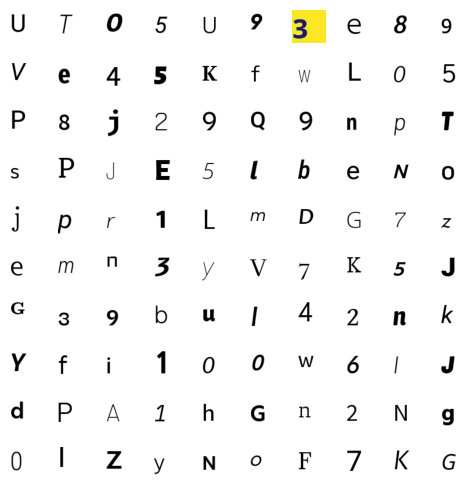

In [7]:
image_files = []
for root, dirs, files in os.walk(df_path):
    for file in files:
        if file.endswith('.png'):
            image_files.append(os.path.join(root, file))

# Sample 100 random images
sampled_images = random.sample(image_files, 100)

# Set up the plot for displaying images (10x10 grid for 100 images)
fig, axes = plt.subplots(10, 10, figsize=(5, 5))

# Loop through the sampled images and plot them
for i, img_path in enumerate(sampled_images):
    ax = axes[i // 10, i % 10]  # Get position in grid
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [8]:
# Sample one random image
sample_image_path = random.choice(image_files)

# Open the image using PIL
img = Image.open(sample_image_path)

In [9]:
# Print the image size
print("Image Size:", img.size)

Image Size: (40, 60)


In [10]:
# Print the number of classes (unique labels)
def directory_to_df(df_path):
    data = []
    for label in os.listdir(df_path):
        label_path = os.path.join(df_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith((".png")):
                    file_path = os.path.join(label_path, file)
                    merged_label = label[0].lower()
                    data.append([file_path, merged_label])
    return pd.DataFrame(data, columns=["image", "label"])
df = directory_to_df(df_path)
num_classes = len(df['label'].unique())
print("Number of Classes:", num_classes)

Number of Classes: 36


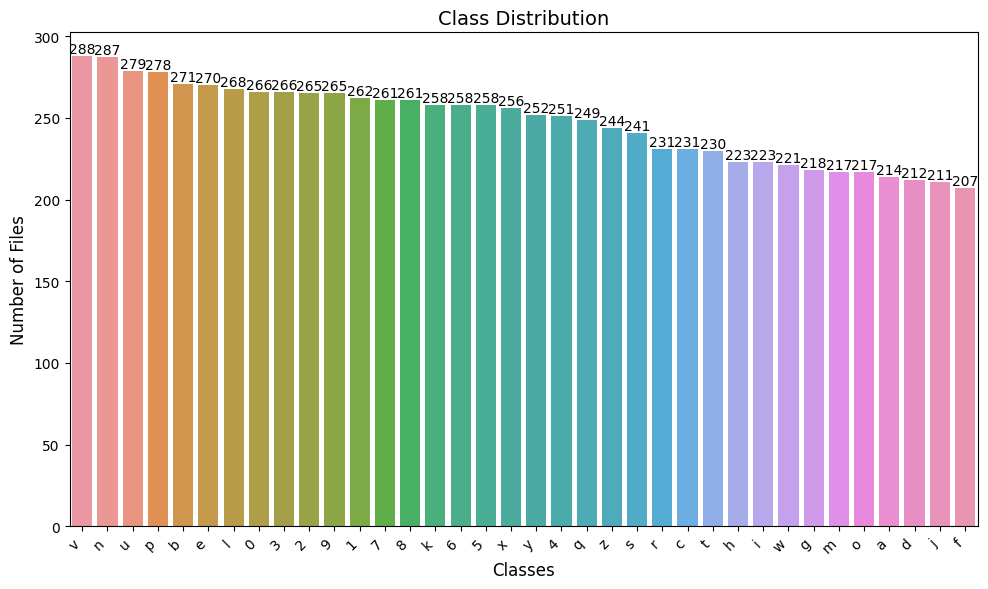

In [11]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=label_counts.index, y=label_counts.values)

# Add labels above each bar displaying the count
for bar, count in zip(bars.patches, label_counts.values):
    bars.annotate(f'{count}', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom', fontsize=10)

plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Files", fontsize=12)
plt.title("Class Distribution", fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

**Dataset Summary**
*   Size: 8.909 PNG images (40 x 60 px).
* Classes: 36 (A-Z, 0-9).
* Source: Collected from Kaggle and supplemented with Python-generated data.
* Cleaning:
  - Removed fonts missing specific symbols.
  - Excluded ambiguous characters (e.g., 'O' vs. '0').
* Format: PNG for uniform quality.
* Use Cases: OCR

## Data Prepocessing

In [12]:
# Pre-defined hyperparameters
# Hyperparameters
IMG_WIDTH = 32
IMG_HEIGHT = 32
CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
BATCH_SIZE = 32
NUM_CLASSES = 36
NUM_EPOCH = 100
LEARNING_RATE = 0.0001

### Data Splitting

In [13]:
# Splitting for training & testing (70/30)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [14]:
# Splitting for training & validation (75/25) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

### Data Augmentation

In [15]:
# Train Data Generator with Augmentations
train_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=10,  # Rotate images up to 10 degrees
    width_shift_range=0.1,  # Shift horizontally by 10% of the width
    height_shift_range=0.1,  # Shift vertically by 10% of the height
    zoom_range=0.2,  # Zoom in/out by up to 20%
    shear_range=0.2,  # Shear transformations
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)

# Validation and Test Data Generators (No Augmentation)
valid_gen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = ImageDataGenerator(rescale=1.0 / 255)

# Flow from dataframe for each dataset
train_gen_flow = train_gen.flow_from_dataframe(
    training_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

valid_gen_flow = valid_gen.flow_from_dataframe(
    validation_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen_flow = test_gen.flow_from_dataframe(
    testing_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4677 validated image filenames belonging to 36 classes.
Found 1559 validated image filenames belonging to 36 classes.
Found 2673 validated image filenames belonging to 36 classes.


In [16]:
def plot_augmented_data(generator, num_samples=5):
    # Get a batch of images and labels
    images, labels = next(generator)
    
    # Create a figure with a grid for displaying images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i])  # Plot the image
        ax.axis('off')  # Turn off axis for clean visualization
        
        # Get the label index and corresponding class name
        class_index = labels[i].argmax()
        class_name = list(generator.class_indices.keys())[class_index]
        ax.set_title(class_name)  # Display class name as the title
    
    plt.tight_layout()
    plt.show()

In [17]:
# Access class indices from the generator
class_indices = train_gen_flow.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Print the class labels
print("Class indices (Class to Index):", class_indices)
print("Class labels (Index to Class):", index_to_class)

Class indices (Class to Index): {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
Class labels (Index to Class): {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


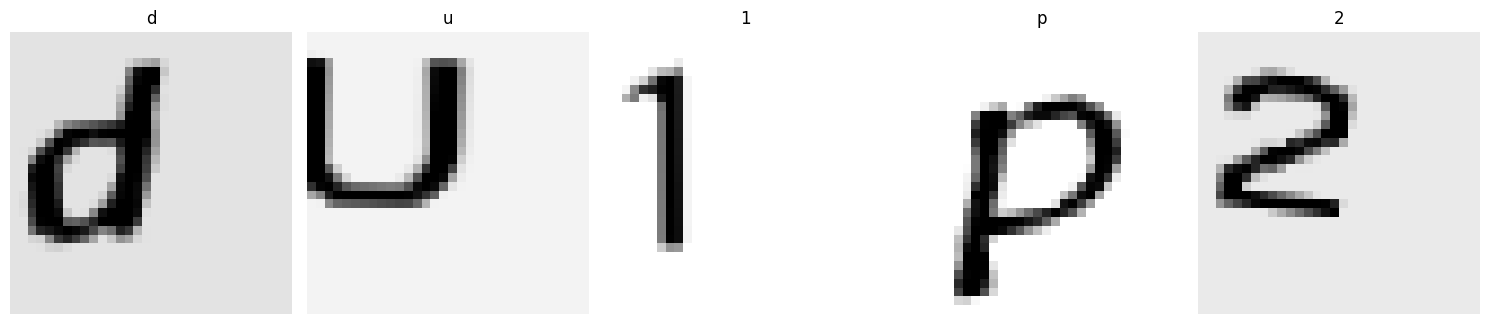

In [18]:
# Plot augmented images
plot_augmented_data(train_gen_flow, num_samples=5)

In [19]:
# Function to convert text labels to numeric encoding
def encode_label(label):
    encoded = [char_to_idx[c] for c in label if c in characters]
    return encoded

# Function to convert numeric encoding back to text
def decode_label(encoded_label):
    decoded = ''.join([idx_to_char[idx] for idx in encoded_label if idx != -1])
    return decoded

## Modelling

In [20]:
def build_crnn_single_char(input_shape, num_classes):
    model = Sequential(name="CRNN_Single_Char")

    # Input Layer
    model.add(Input(shape=input_shape, name="Input"))

    # Convolutional Layers
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Flatten and reshape for LSTM
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))

    # Fully connected layers for character prediction
    model.add(Dense(num_classes, activation="softmax", name="Output"))

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [21]:
model = build_crnn_single_char(IMG_SHAPE, NUM_CLASSES)

In [22]:
model.summary()

Model: "CRNN_Single_Char"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,182,308 (8.32 MB)

 Trainable params: 2,182,308 (8.32 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    train_gen_flow,
    epochs=100,
    validation_data=valid_gen_flow,
)

Epoch 1/100


C:\Users\62877\miniconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.0735 - loss: 3.4762 - val_accuracy: 0.6139 - val_loss: 1.3872
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.4440 - loss: 1.9092 - val_accuracy: 0.8352 - val_loss: 0.5641
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6666 - loss: 1.1284 - val_accuracy: 0.8788 - val_loss: 0.3887
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.7305 - loss: 0.8732 - val_accuracy: 0.9185 - val_loss: 0.2839
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7860 - loss: 0.7226 - val_accuracy: 0.9339 - val_loss: 0.2294
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8139 - loss: 0.6278 - val_accuracy: 0.9423 - val_loss: 0.1921
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8194 - loss: 0.5799 - val_accuracy: 0.9455 - val_loss: 0.1649
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8416 - loss: 0.5174 - val

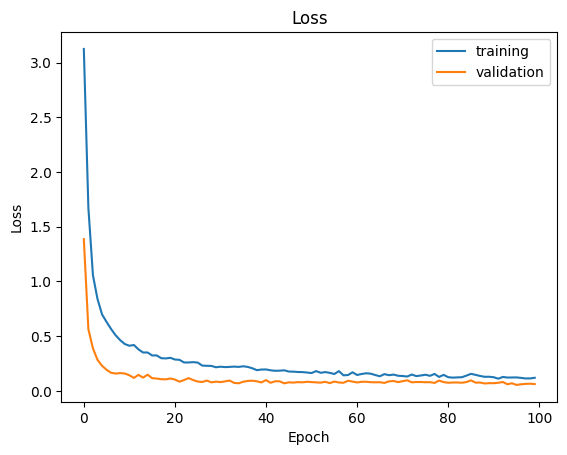

In [24]:
plt.plot(np.arange(0, NUM_EPOCH), history.history["loss"], label="training")
plt.plot(np.arange(0, NUM_EPOCH), history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

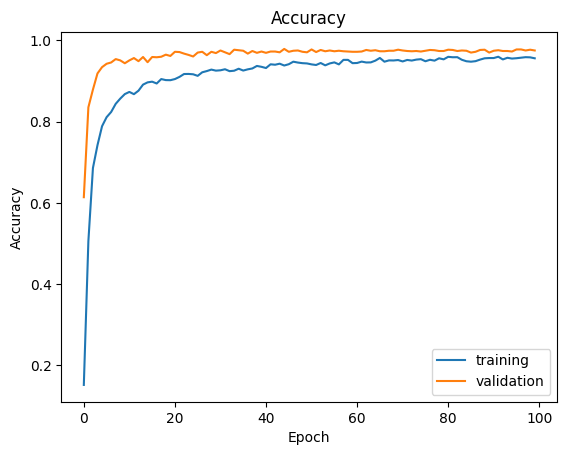

In [25]:
plt.plot(np.arange(0, NUM_EPOCH), history.history["accuracy"], label="training")
plt.plot(np.arange(0, NUM_EPOCH), history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [26]:
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), class_indices.items()))

In [27]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation 
prediction = model.predict(test_gen_flow)
y_pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen_flow.classes))

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        83
           1       1.00      1.00      1.00        77
           2       0.99      1.00      0.99        76
           3       1.00      0.99      0.99        81
           4       1.00      0.99      0.99        77
           5       0.99      0.99      0.99        83
           6       1.00      1.00      1.00        79
           7       0.98      1.00      0.99        79
           8       0.99      1.00      0.99        78
           9       1.00      1.00      1.00        84
           a       0.96      1.00      0.98        66
           b       0.99      0.99      0.99        75
           c       0.99      0.97      0.98        77
           d       1.00      0.98      0.99        61
           e       1.00      0.97      0.99        71
           f       0.97      0.97      0.97        71
           g       0.98      1.00      0.99        56
           h       1.00    

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(generator, model, class_indices, figsize=(12, 10)):
    # Get true labels and predicted labels
    y_true = generator.classes
    y_pred_prob = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Map indices back to class names
    labels = list(class_indices.keys())
    
    # Plot confusion matrix
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


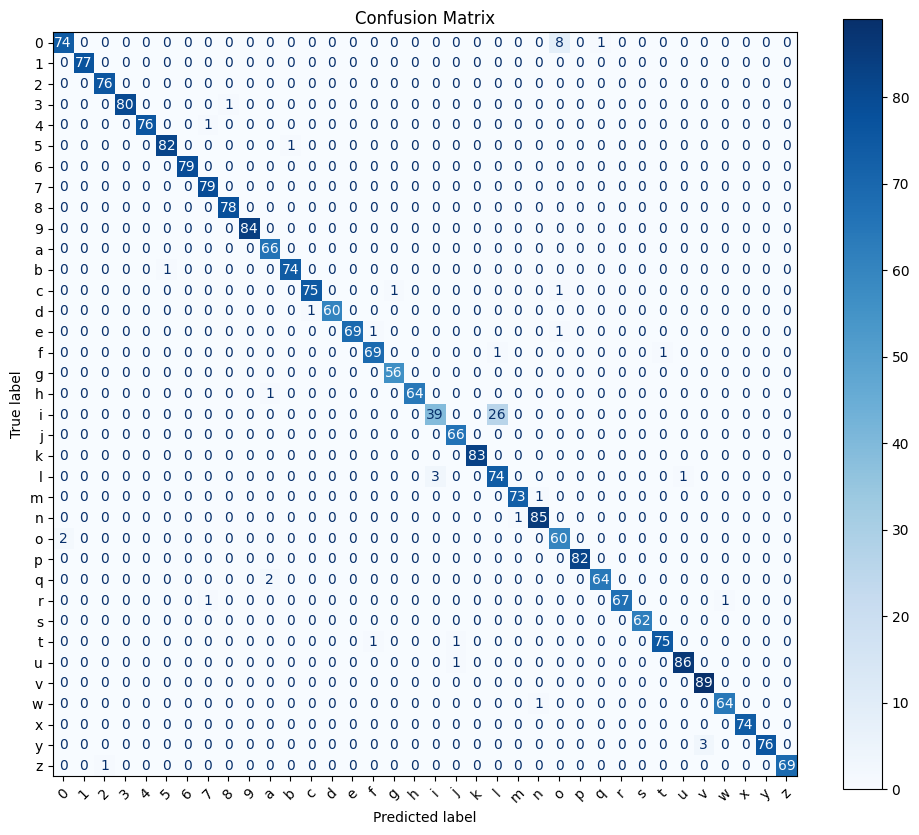

In [30]:
# Plot confusion matrix
plot_confusion_matrix(test_gen_flow, model, train_gen_flow.class_indices)

## Save & Convert Model

In [31]:
export_dir = './saved_model/'
model.save('CRNN-NG-1.h5')
print("Model saved as CRNN-NG-1.h5")

Model saved as CRNN-NG-1.h5


In [32]:
model = tf.keras.models.load_model("CRNN-NG-1.h5")

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\62877\AppData\Local\Temp\tmpilmjrtkf\assets


INFO:tensorflow:Assets written to: C:\Users\62877\AppData\Local\Temp\tmpilmjrtkf\assets


Saved artifact at 'C:\Users\62877\AppData\Local\Temp\tmpilmjrtkf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='Input')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  2475115205856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115209552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115268752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115273152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115432240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115435056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115432064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2475115442800: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [34]:
# Save the converted model to a .tflite fileS
with open("CRNN-NG-1.tflite", "wb") as f:
    f.write(tflite_model)

print("Model has been converted and saved as model.tflite")

Model has been converted and saved as model.tflite


In [35]:
# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# tflite_model = converter.convert()

In [36]:
# tflite_model_file = pathlib.Path('vegs.tflite')
# tflite_model_file.write_bytes(tflite_model)

## Load Model

In [37]:
def load_model():
    model_path = 'CRNN-NG-1.h5'
    model = tf.keras.models.load_model(model_path)
    return model

In [95]:
def convert_2_gray(image):
    # Convert RGB to grayscale if necessary
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image (RGB)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image  # Already grayscale
    return gray_image

def binarization(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    return thresh

def dilate(image, words=False):
    img = image.copy()
    m = 3
    n = m - 2  # Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations=itrs)
    return dilation

def find_rect(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rects.append([x, y, w, h])
    sorted_rects = sorted(rects, key=lambda x: x[0])  # Sort rects left to right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []  # List to store recognized characters

    # Convert image to grayscale
    image_cpy = convert_2_gray(image)

    # Binarization and dilation to detect words
    bin_img = binarization(image_cpy)
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)  # Find bounding boxes for words

    # Draw bounding boxes around detected words
    for word in words:
        x, y, w, h = word
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box for words

        img = image_cpy[y:y + h, x:x + w]  # Crop the word region

        # Binarization and dilation to detect characters
        bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)  # Find bounding boxes for characters
        
        # Track the previous character's x-coordinate
        prev_x_end = 0
        
        for char in char_parts:
            cx, cy, cw, ch = char
            ch_img = img[cy:cy + ch, cx:cx + cw]  # Crop character region
            
            # Detect spacing (if gap between characters is significant)
            if prev_x_end > 0 and cx - prev_x_end > 5:  # Adjust threshold (e.g., 5 pixels)
                chars.append(' ')  # Add a space for significant gaps
            
            # Draw bounding boxes around detected characters
            cv2.rectangle(image, (x + cx, y + cy), (x + cx + cw, y + cy + ch), (255, 0, 0), 1)  # Red box for characters
            
            # Resize character to 32x32 with padding
            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)  # Create a white image
            resized = cv2.resize(ch_img, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3 + 22, 3:3 + 16, 0] = gray  # Place resized character in the center

            # Convert to RGB and normalize
            gray_rgb = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray_rgb = gray_rgb.astype(np.float32) / 255.0

            # Predict the character
            prediction = model.predict(np.array([gray_rgb]), verbose=0)
            predicted_char = mapping_inverse[np.argmax(prediction)]
            chars.append(predicted_char)  # Append the recognized character
            
            # Update previous character's x-end
            prev_x_end = cx + cw
        
        # Add a space after each word
        chars.append(' ')
    
    # Visualize the detected words and bounding boxes (optional)
    show_image(image)

    # Join characters into a single string and remove trailing spaces
    return ''.join(chars).strip()

def read_image(image_path):
    # Read the image from the specified file path
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image from {image_path}. Please check the file path.")
    return image

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')  # Hide axes
    plt.show()

In [96]:
mapping_inverse = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
                   6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 
                   12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 
                   18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 
                   24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 
                   30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}
print(mapping_inverse)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


## Testing

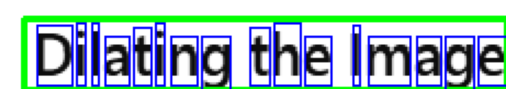

Extracted Text:  di1ating the nmage


In [97]:
# Testing 1
img = read_image('./testing/images/2.png')
text = extract(img)
print('Extracted Text: ',text)

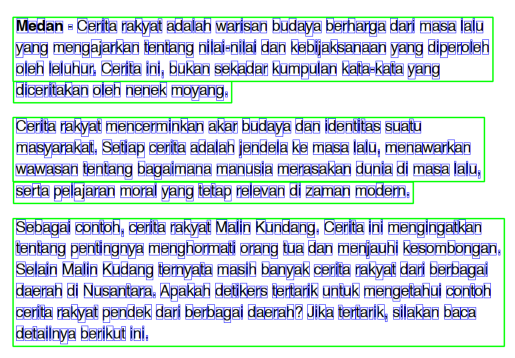

Extracted Text:  tdcdsseeeaeenrteibtaiataraaiaiinngnhrgayamdaikpaciyeboinainenntutrtisipknokaeguhunnndt7 tdycaianeaenrikarngmintdataeeanprrrangiaykbhkyaeaoatrhratbmdammageatataiiiskioiniedhrarkasbneuagtrneandtryhutaaa2anrkjgidkciankeucnarneittmteauriertktranaamjrkianiyekuia7nhmtgsi deiekiaatneakgrshiaionbunmgei bacrbbaotokacnnagatgonaahinn wcmaeawrsityaaasrraaankkyateatnntstmaenetginacpbeacrgmeariiintmakaaanndaaaimkaaharnjbeuunsddiaaeyimaaekdreaasmnaaikdsaeannt1daituiaunsjiamsudeaintmuawasaarkiaaniu7 yomaieenhdgaiemn1uenhncugeranrciatarekrraiatnakytienanitjtaabdunagkiaannhiiasweinaknraiiisadaiandrakbnuumdkaepybuai1jaabnkeskrahanataargnakanadtyaaanryigamndgaipsear1oaiieuh seha peiaaran morai yang tetap re1evan di zaman modernn diceritakan oieh nenek moyangn


In [98]:
# Testing 1
img = read_image('./testing/images/7.png')
text = extract(img)
print('Extracted Text: ',text)

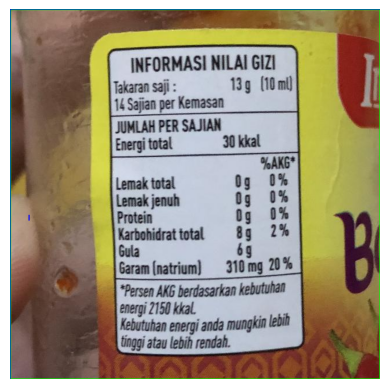

Extracted Text:  at


In [90]:
# Testing 1
img = read_image('./testing/images/4.jpg')
text = extract(img)
print('Extracted Text: ',text)

In [45]:
import pytesseract
import random
import re
import json

def find_text_blocks(image):
    binary_image = binarization(image)  # Binarisasi gambar
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    blocks = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 50 and h > 20:  # Hanya blok teks yang cukup besar
            blocks.append([x, y, w, h])

    # Urutkan blok teks berdasarkan posisi top-to-bottom, left-to-right
    blocks = sorted(blocks, key=lambda b: (b[1], b[0]))
    return blocks

# Koreksi rotasi gambar
def deskew_image(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return deskewed

# Preprocessing lengkap untuk OCR
def preprocess_image(image):
    gray = convert_2_gray(image)
    deskewed = deskew_image(gray)
    binary = binarization(deskewed)
    return binary
def extract_text_from_block(image):
    processed_image = preprocess_image(image)
    text_blocks = find_text_blocks(processed_image)
    
    if not text_blocks:
        return "No text found."

    full_text = ""
    for block in text_blocks:
        x, y, w, h = block
        block_img = image[y:y+h, x:x+w]
        text = pytesseract.image_to_string(block_img, config='--psm 6')  # Mode untuk blok teks
        full_text += text.strip() + "\n"

    return full_text.strip()

# Membaca teks dari gambar
def read_story_text(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Tidak dapat membaca gambar dari path yang diberikan.")
    text = extract_text_from_block(image)
    return text

In [46]:
# Fungsi untuk parsing informasi nutrisi
def parse_nutrition_info(extracted_text):
    nutrition_data = {}
    
    # Regex for each nutritional data
    serving_size = re.search(r'Serving Size|Takaran Saji\s*[:\-\s]*([0-9]+g)', extracted_text, re.IGNORECASE)
    calories = re.search(r'Calories\s*[:\-\s]*([0-9]+)', extracted_text, re.IGNORECASE)
    total_fat = re.search(r'Total Fat\s*[:\-\s]*([0-9]+g)', extracted_text, re.IGNORECASE)
    saturated_fat = re.search(r'Saturated Fat\s*[:\-\s]*([0-9]+g)', extracted_text, re.IGNORECASE)
    cholesterol = re.search(r'Cholesterol\s*[:\-\s]*([0-9]+mg)', extracted_text, re.IGNORECASE)
    sodium = re.search(r'Sodium\s*[:\-\s]*([0-9]+mg)', extracted_text, re.IGNORECASE)
    protein = re.search(r'Protein\s*[:\-\s]*([0-9]+g)', extracted_text, re.IGNORECASE)
    
    # Define sugar types to capture (including different names for sugars)
    sugar_variations = [
        'Sugars', 'Gula', 'Sucrose', 'Fructose', 'Glucose', 'Lactose', 'Maltose', 
        'High\s*fructose\s*corn\s*syru', 'Gula\s*Pasir', 'Gula\s*Kelapa', 
        'Gula\s*Aren', 'Gula\s*Merah', 'Gola/Sugar'
    ]
    
    # Dictionary to store specific sugar types
    sugars = {}

    for sugar in sugar_variations:
        # First match: sugar value with optional 'g'
        match_optional_g = re.search(rf'{sugar}\s*[:\-\s]*([0-9]+)(g)?', extracted_text, re.IGNORECASE)
        if match_optional_g:
            sugar_value = match_optional_g.group(1)  # Get the numeric value
            if match_optional_g.group(2) is None:  # If 'g' was not present
                sugar_value += 'g'  # Append 'g'
            sugars[sugar] = sugar_value  # Store the specific sugar type found in the dictionary

        # Second match: sugar value that must include 'g'
        match_must_have_g = re.search(rf'{sugar}\s*[:\-\s]*([0-9]+g)', extracted_text, re.IGNORECASE)
        if match_must_have_g:
            sugar_value = match_must_have_g.group(1)  # Get the value which includes 'g'
            sugars[sugar] = sugar_value  # Store the specific sugar type found in the dictionary

    # Add sugars to the main nutrition data
    if sugars:
        nutrition_data['Sugars'] = sugars  # Store all detected sugars in a sub-dictionary
    
    # Insert the parsed results into the dictionary
    if serving_size:
        nutrition_data['Serving Size'] = serving_size.group(1)
    if calories:
        nutrition_data['Calories'] = int(calories.group(1))
    if total_fat:
        nutrition_data['Total Fat'] = total_fat.group(1)
    if saturated_fat:
        nutrition_data['Saturated Fat'] = saturated_fat.group(1)
    if cholesterol:
        nutrition_data['Cholesterol'] = cholesterol.group(1)
    if sodium:
        nutrition_data['Sodium'] = sodium.group(1)
    if protein:
        nutrition_data['Protein'] = protein.group(1)
    
    return nutrition_data

In [47]:
# Test the process
image_path = './testing/images/1.png'  # Replace with your image path

try:
    # Read the text from the image
    story_text = read_story_text(image_path)
    print("Extracted Text from Image:\n")
    print(story_text)  # Debugging: print the OCR result

    # Parse the nutrition information from the extracted text
    nutrition_info = parse_nutrition_info(story_text)
    
    # Convert the parsed data to JSON format with indentation
    nutrition_json = json.dumps(nutrition_info, indent=4)
    
    print("\nParsed Nutrition Information in JSON Format:\n")
    print(nutrition_json)
    
except Exception as e:
    print(f"Error occurred while reading the image or processing the text: {e}")

Extracted Text from Image:

EDITABLE AND RESIZABLE
NUTRITION FACTS
SS

Amount Per 500g
- %Daily Value*
Calories 300
Total Fat 16g
- Saturated Fat 10g
Cholesterol 60mg
Sodium 250mg
Total Carbohydrates —~=~S=« AG
~-Dietary Fiber Og

- Sugars 24g
Protein 16g
Vitamin D 7.5mcg (38% DV)
Potassium 698mg (15% DV)
Calcium 552mg (42% DV)
Iron 0.2mg (1% DV)
ee
‘Copronmoen end con very beeen octors whos ipenees eng banana es
NUTRITION FACTS
SS
Amount Per 500g
_ 7 %Daily Value*
Calories 300
Total Fat 16g

- Saturated Fat 10g
Cholesterol 60mg
Sodium 250mg
Total Carbohydrates 249

~-Dietary Fiber Og
~ Sugars 24g
Protein 16g
esta fe = ©... fane mast

Parsed Nutrition Information in JSON Format:

{
    "Sugars": {
        "Sugars": "24g"
    },
    "Calories": 300,
    "Total Fat": "16g",
    "Saturated Fat": "10g",
    "Cholesterol": "60mg",
    "Sodium": "250mg",
    "Protein": "16g"
}
